In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

In [2]:
# Define Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook for forward activations
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()

        # Forward pass to get outputs
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output)

        # Backpropagate gradients for the target class
        self.model.zero_grad()
        output[:, target_class].backward()

        # Compute the Grad-CAM
        gradients = self.gradients.detach().cpu().numpy()  # Detach gradients before converting
        activations = self.activations.detach().cpu().numpy()  # Detach activations before converting
        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize
        return cam

In [3]:
# Preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

In [4]:

# Load the model architecture and weights
def load_model(model_path):
    model = torchvision.models.vgg16(pretrained=False)  # Example: VGG16
    model.classifier[6] = nn.Linear(in_features=4096, out_features=2)  # Adjust the last layer for binary classification
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))  # Load the model weights
    model.eval()  # Set model to evaluation mode
    return model


In [5]:
# Function to predict and generate heatmap
def predict_and_generate_heatmap(model, image_path, target_layer, ground_truth_label):
    input_tensor = preprocess_image(image_path).to(device)
    
    # Initialize Grad-CAM
    gradcam = GradCAM(model=model, target_layer=target_layer)

    # Generate the heatmap
    cam = gradcam.generate_cam(input_tensor)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = "Infected" if predicted.item() == 1 else "Uninfected"

    # Confusion Matrix Calculation
    actual_label = ground_truth_label  # Use ground truth label provided
    return actual_label, predicted.item(), cam, predicted_label


In [6]:
# Function to evaluate all images in a folder
def evaluate_images_in_folder(model, folder_path, target_layer):
    # Lists to collect predictions and ground truth labels
    all_actual_labels = []
    all_predicted_labels = []
    
    # Process all images in the directory
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        
        if os.path.isdir(subfolder_path):
            ground_truth_label = 1 if subfolder == "infected" else 0  # Set ground truth based on folder name

            for filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, filename)

                actual_label, predicted_label, cam, predicted_label_str = predict_and_generate_heatmap(
                    model, image_path, target_layer, ground_truth_label
                )

                all_actual_labels.append(actual_label)
                all_predicted_labels.append(predicted_label)
    
    # Compute confusion matrix
    cm = confusion_matrix(all_actual_labels, all_predicted_labels)

    # Generate classification report
    report = classification_report(all_actual_labels, all_predicted_labels, target_names=["Uninfected", "Infected"], output_dict=True)

    # Visualize confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Uninfected", "Infected"], yticklabels=["Uninfected", "Infected"])
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(f"Accuracy: {report['accuracy']:.2f}")
    print(f"Precision (Uninfected): {report['Uninfected']['precision']:.2f}")
    print(f"Recall (Uninfected): {report['Uninfected']['recall']:.2f}")
    print(f"F1-Score (Uninfected): {report['Uninfected']['f1-score']:.2f}")
    print(f"Precision (Infected): {report['Infected']['precision']:.2f}")
    print(f"Recall (Infected): {report['Infected']['recall']:.2f}")
    print(f"F1-Score (Infected): {report['Infected']['f1-score']:.2f}")

/home/hausemaster/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hausemaster/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_26595/517888218.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `Tr

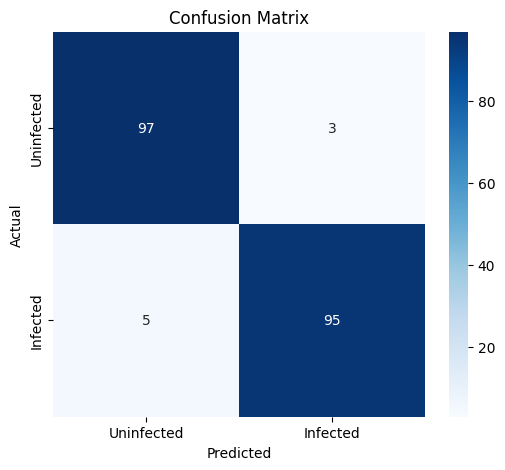


Classification Report:
Accuracy: 0.96
Precision (Uninfected): 0.95
Recall (Uninfected): 0.97
F1-Score (Uninfected): 0.96
Precision (Infected): 0.97
Recall (Infected): 0.95
F1-Score (Infected): 0.96


In [7]:
# Main execution
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model (make sure the path is correct)
    model_path = "cancer_model_full_dataset.pth"  # Path to your saved model
    model = load_model(model_path).to(device)

    # Folder path containing images (e.g., "test_eval/infected/" and "test_eval/uninfected/")
    folder_path = "TEST_METRICS"  # Path to the parent folder containing "infected" and "uninfected"
    target_layer = model.features[29]  # Set the target layer for Grad-CAM
    
    # Evaluate all images in the folder and generate confusion matrix
    evaluate_images_in_folder(model, folder_path, target_layer)